In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.models import resnet18
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import random
import gc

In [2]:
# Check if GPU is available 
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Paths
train_dir = r'G:\TheErdosInstitution\DS_2024\DS2024_facial_expression\raw_data\fer2013\train'
test_dir = r'G:\TheErdosInstitution\DS_2024\DS2024_facial_expression\raw_data\fer2013\test'

In [30]:
random.seed(2024)
torch.manual_seed(2024)
# Data Transformations
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets and Dataloaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [24]:
# Print category information
print("Categories and number of images in each category (Training):")
for category, index in train_dataset.class_to_idx.items():
    print(f"{category}: {sum([label == index for _, label in train_dataset])} images")

print("Categories and number of images in each category (Testing):")
for category, index in test_dataset.class_to_idx.items():
    print(f"{category}: {sum([label == index for _, label in test_dataset])} images")

Categories and number of images in each category (Training):
angry: 3995 images
disgust: 436 images
fear: 4097 images
happy: 7215 images
neutral: 4965 images
sad: 4830 images
surprise: 3171 images
Categories and number of images in each category (Testing):
angry: 958 images
disgust: 111 images
fear: 1024 images
happy: 1774 images
neutral: 1233 images
sad: 1247 images
surprise: 831 images


In [31]:
# Define the CNN Model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [32]:
# Instantiate Model
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=50, verbose=True)

c:\Users\shiru\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [33]:
random.seed(2024)
torch.manual_seed(2024)

# Training Loop

# Lists to store accuracy values
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

# Train the model
num_epochs = 120
for epoch in range(num_epochs):  # loop over the dataset multiple times
    model.train()
    # ... training loop ...
    start_time = time.time()
    
    # Training loop 
    running_loss = 0  # Initialize running loss for the epoch
    
    correct = 0
    total = 0
    
    # Calculate training accuracy and loss
    total = 0
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        running_loss += loss.item()  # Accumulate loss
        
    train_accuracy = 100 * correct/total
    train_accuracies.append(train_accuracy)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Calculate test accuracy and loss
    # testing loop
    model.eval()
    running_loss = 0  # Initialize running loss for the epoch
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
        
            loss = criterion(outputs, labels)
        
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()  # Accumulate loss
        
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    
    # Calculate average training loss for the epoch
    epoch_test_loss = running_loss / len(test_loader)
    test_losses.append(epoch_test_loss)
    
    end_time = time.time()  # Record the end time of the epoch
    epoch_time = end_time - start_time  # Calculate the epoch time
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Time: {epoch_time:.2f} seconds')
print(f"Best Accuracy: {max(test_accuracies):.4f}")

Epoch [1/120], Train Accuracy: 38.061235152739556%, Test Accuracy: 47.380886040679854%, Train Loss: 1.6114, Test Loss: 1.3860, Time: 25.05 seconds
Epoch [2/120], Train Accuracy: 47.58438120450033%, Test Accuracy: 49.76316522708275%, Train Loss: 1.3762, Test Loss: 1.3104, Time: 24.90 seconds
Epoch [3/120], Train Accuracy: 50.384896722282214%, Test Accuracy: 51.61604903872945%, Train Loss: 1.3014, Test Loss: 1.2731, Time: 23.31 seconds
Epoch [4/120], Train Accuracy: 52.485283360618624%, Test Accuracy: 53.84508219559766%, Train Loss: 1.2608, Test Loss: 1.1992, Time: 23.20 seconds
Epoch [5/120], Train Accuracy: 53.51980215263506%, Test Accuracy: 55.25215937587072%, Train Loss: 1.2292, Test Loss: 1.2296, Time: 23.99 seconds
Epoch [6/120], Train Accuracy: 54.29656205371138%, Test Accuracy: 55.82334912231819%, Train Loss: 1.2098, Test Loss: 1.1871, Time: 23.49 seconds
Epoch [7/120], Train Accuracy: 55.24051691107318%, Test Accuracy: 56.51992198383951%, Train Loss: 1.1830, Test Loss: 1.2142, T

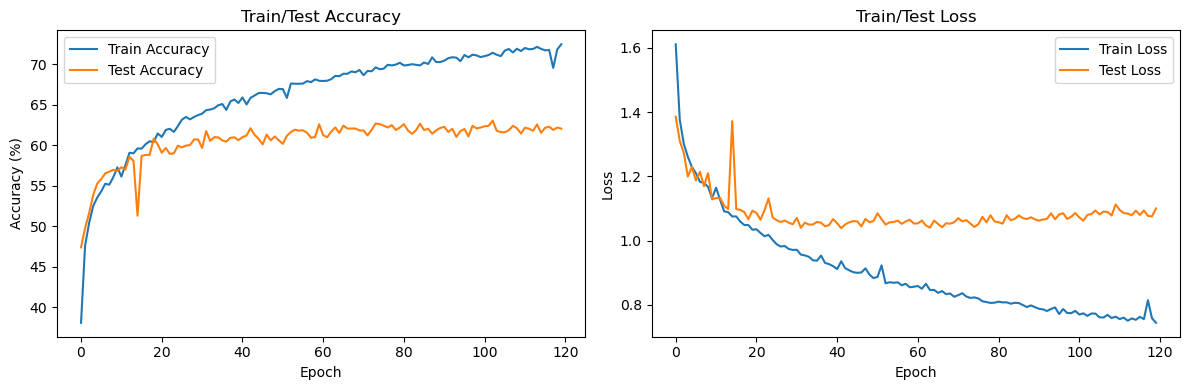

In [36]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train/Test Accuracy')
plt.legend()

plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Test Loss')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [37]:
# model summarization
print(model)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=128, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, tra

In [38]:
# Save the trained model
torch.save(model.state_dict(), 'CNN_Best_Model.pth')

# load model
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('CNN_Best_Model.pth', weights_only=True))
# model.eval()

NameError: name 'models' is not defined